In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from imblearn.over_sampling import SMOTE
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Original Training Data Distribution:
Training_Program
0    26
2    24
3    22
1    21
4    18
5    18
6    12
7    11
Name: count, dtype: int64

Training Data Distribution After SMOTE:
Training_Program
7    26
1    26
2    26
4    26
6    26
3    26
5    26
0    26
Name: count, dtype: int64
Fitting 4 folds for each of 30 candidates, totalling 120 fits
Best Parameters for KNN: {'weights': 'distance', 'p': 2, 'n_neighbors': 3, 'metric': 'minkowski'}
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.71      0.83         7
           1       0.60      0.60      0.60         5
           2       0.50      0.83      0.62         6
           3       0.40      0.33      0.36         6
           4       0.25      0.20      0.22         5
           5       0.50      0.50      0.50         4
           6       0.67      0.67      0.67         3
           7       0.67      0.67      0.67         3

    accuracy                         

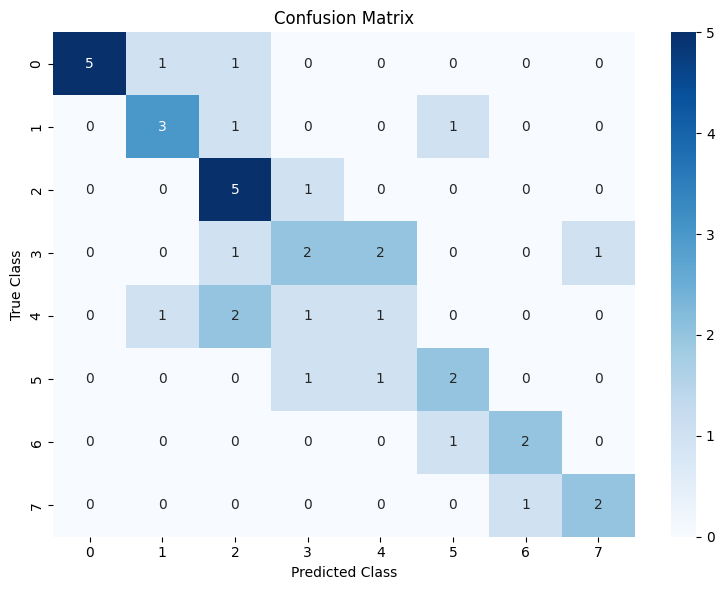

Permutation Importance for KNN:
              Feature  Importance
5   sports_experience    0.145299
7               goals    0.134188
6            body_fat    0.131624
16              hip_c    0.106838
10     W/Height_Ratio    0.102564
4       resting_pulse    0.095726
1              height    0.095726
9         W/Hip_Ratio    0.094017
8                 BMI    0.091453
15            waist_c    0.066667
3                 age    0.058120
2              weight    0.044444
0              gender    0.036752
13        right_arm_c    0.023077
14         left_arm_c    0.017094
17        upper_leg_c    0.017094
18          lower_leg    0.017094
12            chest_c    0.010256
11         shoulder_c    0.000855


C:\Users\licop\AppData\Local\Temp\ipykernel_9372\2550037205.py:95: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=knn_importances, x='Importance', y='Feature', palette='viridis')


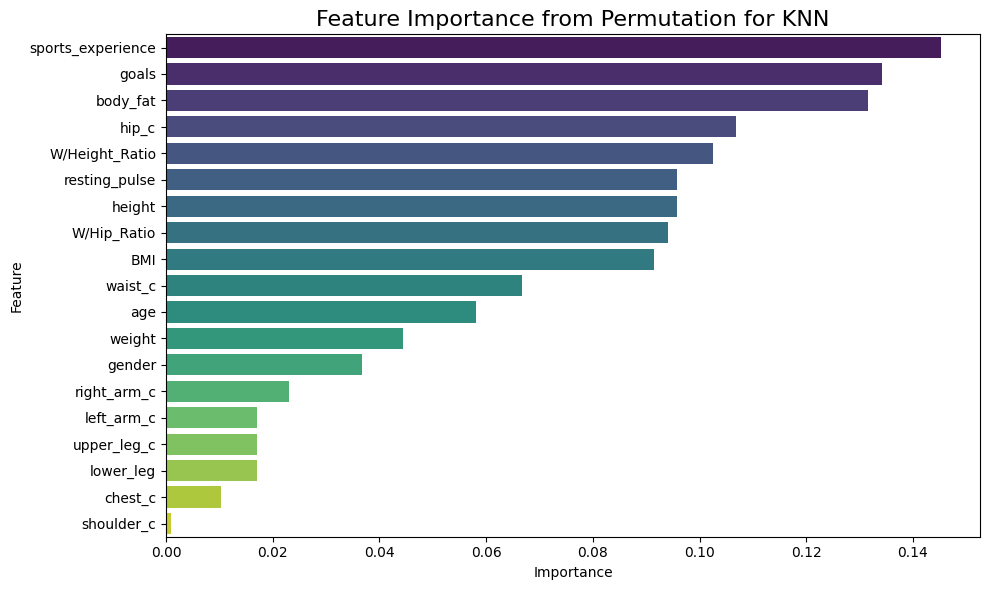

In [17]:
# Load the dataset
VT = pd.read_csv("data/processed_VT_Data.csv")
pd.set_option('display.max_columns', None)

# Separate features and target variable
X = VT.drop(columns=["Training_Program", "surgeries", "chronic_conditions"])
y = VT["Training_Program"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12, stratify=y)

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Generate synthetic data with SMOTE
smote = SMOTE(random_state=12)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Original Training Data Distribution:")
print(pd.Series(y_train).value_counts())
print("\nTraining Data Distribution After SMOTE:")
print(pd.Series(y_train_resampled).value_counts())

# Define the KNN model
knn_model = KNeighborsClassifier()

# Define hyperparameters for optimization
param_dist = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'p': [1, 2]  # for Manhattan (1) and Euclidean (2)
}

# Perform Randomized Search with Cross-Validation
random_search_knn = RandomizedSearchCV(
    estimator=knn_model,
    param_distributions=param_dist,
    n_iter=30,
    scoring='accuracy',
    cv=4,
    random_state=12,
    verbose=1,
    n_jobs=-1
)

# Fit the RandomizedSearchCV
random_search_knn.fit(X_train_resampled, y_train_resampled)

# Best parameters and model performance
print("Best Parameters for KNN:", random_search_knn.best_params_)

# Evaluate the best model
best_knn = random_search_knn.best_estimator_
y_pred_knn = best_knn.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred_knn))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_knn)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=best_knn.classes_, yticklabels=best_knn.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.tight_layout()
plt.show()


# Calculate Permutation Importance
perm_importance_knn = permutation_importance(best_knn, X_test, y_test, n_repeats=30, random_state=42)

# Store permutation importance in a DataFrame
knn_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm_importance_knn.importances_mean
}).sort_values(by='Importance', ascending=False)

# Display the feature importances
print("Permutation Importance for KNN:")
print(knn_importances)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(data=knn_importances, x='Importance', y='Feature', palette='viridis')
plt.title('Feature Importance from Permutation for KNN', fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
perm_importance_knn = permutation_importance(knn, X, y, n_repeats=30, random_state=42)
knn_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm_importance_knn.importances_mean
}).sort_values(by='Importance', ascending=False)